In [64]:
import itertools
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

In [2]:
f = open('databall.pkl')
X, X_train, X_test, y, y_train, y_test = pickle.load(f)
f.close()

[confusion matrix](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

In [3]:
# This function prints and plots the confusion matrix.
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(visible=False)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%d\n%.2f%%' % (cm[i, j], cm_norm[i, j]*100),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [52]:
def plot_performance_curves(models, X, y):
    plt.figure(figsize=(16, 6))
    
    for label, model in models.items():
        prob = model.predict_proba(X)
        
        # Plot ROC curve
        ax = plt.subplot(121)
        fpr, tpr, thresholds = roc_curve(y, prob[:, 1])
        roc_auc = roc_auc_score(y, prob[:, 1])
        ax.plot(fpr, tpr, label='%s (Area = %0.2f)' % (label, roc_auc))
        
        # Plot precision/recall curve
        ax = plt.subplot(122)
        precision, recall, thresholds = precision_recall_curve(y, prob[:, 1])
        pr_auc = average_precision_score(y, prob[:, 1])
        ax.plot(recall, precision, label='%s (Area = %0.2f)' % (label, pr_auc))
        
    ax = plt.subplot(121)
    ax.legend()
    
    ax = plt.subplot(122)
    ax.legend()
    
    plt.show()

In [72]:
models = OrderedDict()
attributes = ['TEAM_SRS','TEAM_SRS_AWAY']

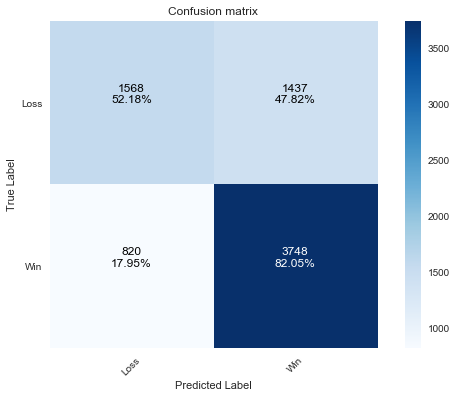

             precision    recall  f1-score   support

          0      0.657     0.522     0.581      3005
          1      0.723     0.820     0.769      4568

avg / total      0.697     0.702     0.694      7573



In [73]:
model = LogisticRegression()
model.fit(X_train[attributes], y_train)
models['Logistic Regression'] = model
pred = model.predict(X_test[attributes])
plot_confusion_matrix(confusion_matrix(y_test, pred), ['Loss', 'Win'])
print classification_report(y_test, pred, digits=3)

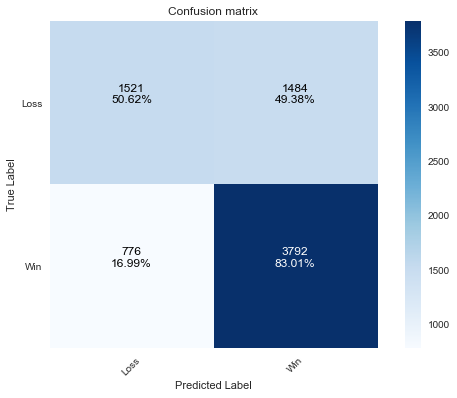

             precision    recall  f1-score   support

          0      0.662     0.506     0.574      3005
          1      0.719     0.830     0.770      4568

avg / total      0.696     0.702     0.692      7573



In [74]:
model = GaussianNB()
model.fit(X_train[attributes], y_train)
models['Naive Bayes'] = model
pred = model.predict(X_test[attributes])
plot_confusion_matrix(confusion_matrix(y_test, pred), ['Loss', 'Win'])
print classification_report(y_test, pred, digits=3)

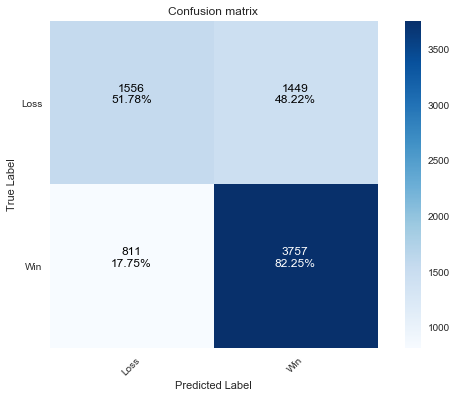

             precision    recall  f1-score   support

          0      0.657     0.518     0.579      3005
          1      0.722     0.822     0.769      4568

avg / total      0.696     0.702     0.694      7573



In [75]:
model = LinearSVC()
model.fit(X_train[attributes], y_train)
pred = model.predict(X_test[attributes])

model = CalibratedClassifierCV(model, cv='prefit')
model.fit(X_train[attributes], y_train)
models['Support Vector Machine'] = model

plot_confusion_matrix(confusion_matrix(y_test, pred), ['Loss', 'Win'])
print classification_report(y_test, pred, digits=3)

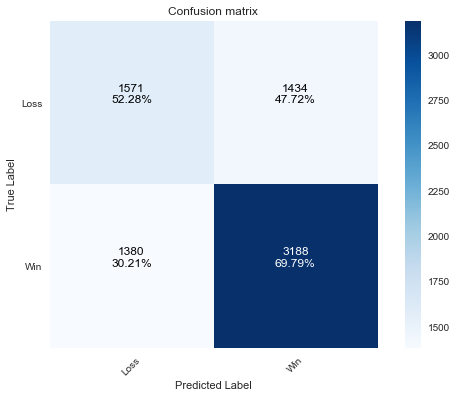

             precision    recall  f1-score   support

          0      0.532     0.523     0.528      3005
          1      0.690     0.698     0.694      4568

avg / total      0.627     0.628     0.628      7573



In [76]:
model = RandomForestClassifier()
model.fit(X_train[attributes], y_train)
models['Random Forest'] = model
pred = model.predict(X_test[attributes])
plot_confusion_matrix(confusion_matrix(y_test, pred), ['Loss', 'Win'])
print classification_report(y_test, pred, digits=3)

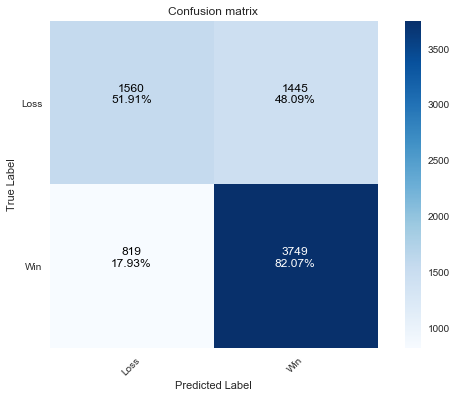

             precision    recall  f1-score   support

          0      0.656     0.519     0.579      3005
          1      0.722     0.821     0.768      4568

avg / total      0.696     0.701     0.693      7573



In [77]:
model = MLPClassifier()
model.fit(X_train[attributes], y_train)
models['Neural Network'] = model
pred = model.predict(X_test[attributes])
plot_confusion_matrix(confusion_matrix(y_test, pred), ['Loss', 'Win'])
print classification_report(y_test, pred, digits=3)

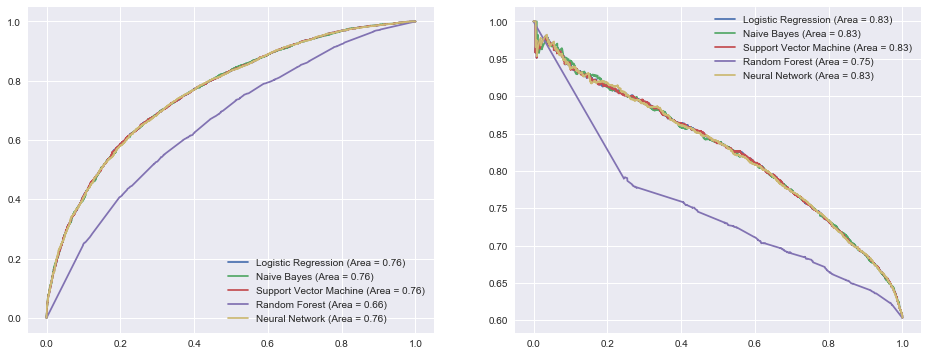

In [78]:
plot_performance_curves(models, X_test[attributes], y_test)